In [2]:
import xarray as xr
import now
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
from scipy.ndimage import label, generate_binary_structure
import time
from cartopy import config
import cartopy.crs as ccrs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://10.0.64.21/17769/1 Dashboard: http://localhost:38239/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [18]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futSev = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc')
pastSev = xr.open_dataarray(localDir + 'severityMHWNOW_pastRun.nc')

## Finding max severity in future and past MHWs

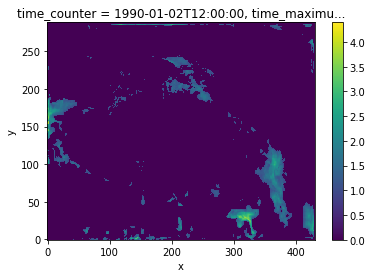

In [9]:
futSev.isel(time_counter = 1).plot();

In [21]:
futSev = futSev.chunk({'x' : 200, 'y' : 200})
futSev

<xarray.DataArray (time_counter: 6940, y: 289, x: 431)>
dask.array<shape=(6940, 289, 431), dtype=float64, chunksize=(6940, 200, 200)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(289, 431), chunksize=(200, 200)>
    nav_lon          (y, x) float32 dask.array<shape=(289, 431), chunksize=(200, 200)>
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(6940,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(6940,)>
    simulation       |S7 ...
Dimensions without coordinates: y, x

In [ ]:
max(futSev)

In [39]:
# Need to find the max severity for each gridpoint across the time-series and save it into a variable.
maxSev = futSev.groupby('nav_lon').groups#.max(dim = 'time_counter')
maxSev

{82.76911926269531: [0],
 82.91969299316406: [431],
 83.0041275024414: [1],
 83.0693588256836: [862],
 83.1546630859375: [432],
 83.21810150146484: [1293],
 83.23957824707031: [2],
 83.30427551269531: [863],
 83.36592102050781: [1724],
 83.39006042480469: [433],
 83.45294189453125: [1294],
 83.47565460205078: [3],
 83.5128402709961: [2155],
 83.53961944580078: [864],
 83.60071563720703: [1725],
 83.6260986328125: [434],
 83.65887451171875: [2586],
 83.68824005126953: [1295],
 83.71220397949219: [4],
 83.74756622314453: [2156],
 83.77558135986328: [865],
 83.80402374267578: [3017],
 83.8359375: [1726],
 83.86258697509766: [435],
 83.89353942871094: [2587],
 83.92414093017578: [1296],
 83.94829559326172: [3448],
 83.94928741455078: [5],
 83.98273468017578: [2157],
 84.01200866699219: [866],
 84.03861236572266: [3018],
 84.07176971435547: [1727],
 84.09171295166016: [3879],
 84.099609375: [436],
 84.12862396240234: [2588],
 84.16050720214844: [1297],
 84.18281555175781: [3449],
 84.186981

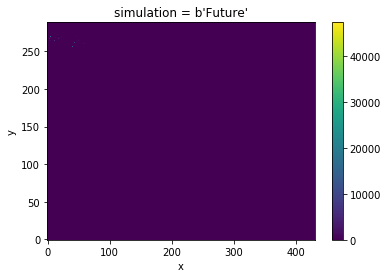

In [26]:
maxSev.plot()

In [35]:
l = futSev.isel(x = 1, y =1).load()

In [36]:
max(l)

<xarray.DataArray ()>
array(2.382801)
Coordinates:
    nav_lat          float32 -43.181286
    nav_lon          float32 83.15466
    time_counter     datetime64[ns] 1991-04-01T12:00:00
    time_maximum_1d  datetime64[ns] 1991-04-01T12:00:00
    time_minimum_1d  datetime64[ns] 1991-04-01T12:00:00
    simulation       |S7 b'Future'